# lgbm-stacking 데모
* 알고리즘 rf, lgbm, lr 적용한 앙상블 기법  stacking 적용
* 개별 모델이 예측한 데이터를 다시ㅣ training set 으로 사용해서 학습  

## 라이브러리 import 및 설정

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline
import lightgbm as lgb
from matplotlib import pyplot as plt
from matplotlib import rcParams
import numpy as np
from pathlib import Path
import pandas as pd
from sklearn.metrics import accuracy_score
from sklearn.model_selection import StratifiedKFold
import seaborn as sns
import warnings
rcParams['figure.figsize'] = (16, 8)       #그림 사이즈 지정
plt.style.use('fivethirtyeight')           #그림 기본 스타일
pd.set_option('max_columns', 100)          #칼럼 100개 허용
pd.set_option("display.precision", 4)      #소수점 4자리허용
warnings.simplefilter('ignore')            #경고분 무시

## 학습데이터 로드

In [2]:
feature_file = 'C:\\Users\\USER\\Desktop\\Dataset\\DataInput\\feature.csv'
sample_file  = 'C:\\Users\\USER\\Desktop\\Dataset\\DataInput\\sample_submission.csv'
tst_file     = 'C:\\Users\\USER\\Desktop\\Dataset\\DataInput\\testset.csv'
trn_file     = 'C:\\Users\\USER\\Desktop\\Dataset\\DataInput\\trainset.csv'
val_dir      = Path('C:\\Users\\USER\\Desktop\\Dataset\\val')
tst_dir      = Path('C:\\Users\\USER\\Desktop\\Dataset\\tst')

## Stacking Feature 생성

In [3]:
model_names = ['lrcvPolyfeature', 'rfcvFeature', 'lgbmcvFeature']
trn = []
tst = []
feature_names = []
for model in model_names:
    trn.append(pd.read_csv(val_dir / f'{model}.val.csv', delimiter=',',header=None))
    tst.append(pd.read_csv(tst_dir / f'{model}.tst.csv', delimiter=',',header=None))
    feature_names += [f'{model}_0CO', f'{model}_1EL', f'{model}_2GR', f'{model}_3HI', f'{model}_4MI', f'{model}_5PH']
    
trn = np.hstack(trn)
tst = np.hstack(tst)
feature_names

['lrcvPolyfeature_0CO',
 'lrcvPolyfeature_1EL',
 'lrcvPolyfeature_2GR',
 'lrcvPolyfeature_3HI',
 'lrcvPolyfeature_4MI',
 'lrcvPolyfeature_5PH',
 'rfcvFeature_0CO',
 'rfcvFeature_1EL',
 'rfcvFeature_2GR',
 'rfcvFeature_3HI',
 'rfcvFeature_4MI',
 'rfcvFeature_5PH',
 'lgbmcvFeature_0CO',
 'lgbmcvFeature_1EL',
 'lgbmcvFeature_2GR',
 'lgbmcvFeature_3HI',
 'lgbmcvFeature_4MI',
 'lgbmcvFeature_5PH']

In [4]:
df = pd.read_csv(trn_file, header=None)
y = pd.DataFrame(df[0].values.flatten())
y.shape

(4280, 1)

In [5]:
seed=150
kfold=10

## Stratified K-Fold Cross Validation
*Stratified N-Fold CV: N-Fold CV에서 각각의 폴드에서 종속변수의 분포가 동일하도록 폴드를 나누는 방식.
현재 사용하는 데이터처럼 분류학습에서 종속변수의 범주의 분포가 균일하지 않을 때 사용된다.

In [6]:
cv = StratifiedKFold(n_splits=kfold, shuffle=True, random_state=seed)

### [범주형 > 수치형 변환_종속변수]

In [7]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn import preprocessing
le = preprocessing.LabelEncoder()

label_str=y
label_int=le.fit_transform(label_str).astype('int')
#target=le.inverse_transform(label_int)
#target
y
label_int

array([3, 5, 2, ..., 1, 5, 1])

In [8]:
p_val = np.zeros((trn.shape[0], 6))
p_tst = np.zeros((tst.shape[0], 6))
for i, (i_trn, i_val) in enumerate(cv.split(trn, y), 1):
    print(f'training model for CV #{i}')
    clf = lgb.LGBMClassifier(objective='multiclass',
                             boosting_type='dart', 
                             n_estimators=300,
                             learning_rate=0.1,
                             num_leaves=64,
                             min_child_samples=10,   
                             subsample=.5,                       
                             subsample_freq=1,    
                             colsample_bytree= 0.8,
                             random_state=seed,
                             n_jobs=-1)
    clf.fit(trn[i_trn], label_int[i_trn],
            eval_set=[(trn[i_val], label_int[i_val])],
            eval_metric='multiclass',
            early_stopping_rounds=15)
    
    p_val[i_val, :] = clf.predict_proba(trn[i_val])
    p_tst += clf.predict_proba(tst) / kfold
print(f'{accuracy_score(label_int, np.argmax(p_val, axis=1)) * 100:.4f}%')

training model for CV #1
[1]	valid_0's multi_logloss: 1.33102
[2]	valid_0's multi_logloss: 1.09895
[3]	valid_0's multi_logloss: 0.929507
[4]	valid_0's multi_logloss: 0.805069
[5]	valid_0's multi_logloss: 0.701803
[6]	valid_0's multi_logloss: 0.624205
[7]	valid_0's multi_logloss: 0.561497
[8]	valid_0's multi_logloss: 0.508411
[9]	valid_0's multi_logloss: 0.508345
[10]	valid_0's multi_logloss: 0.530839
[11]	valid_0's multi_logloss: 0.567155
[12]	valid_0's multi_logloss: 0.512742
[13]	valid_0's multi_logloss: 0.493652
[14]	valid_0's multi_logloss: 0.510012
[15]	valid_0's multi_logloss: 0.468221
[16]	valid_0's multi_logloss: 0.429834
[17]	valid_0's multi_logloss: 0.45933
[18]	valid_0's multi_logloss: 0.423021
[19]	valid_0's multi_logloss: 0.393689
[20]	valid_0's multi_logloss: 0.404867
[21]	valid_0's multi_logloss: 0.37884
[22]	valid_0's multi_logloss: 0.383688
[23]	valid_0's multi_logloss: 0.39294
[24]	valid_0's multi_logloss: 0.368099
[25]	valid_0's multi_logloss: 0.377294
[26]	valid_0's

[214]	valid_0's multi_logloss: 0.305354
[215]	valid_0's multi_logloss: 0.306416
[216]	valid_0's multi_logloss: 0.308867
[217]	valid_0's multi_logloss: 0.307115
[218]	valid_0's multi_logloss: 0.31101
[219]	valid_0's multi_logloss: 0.313851
[220]	valid_0's multi_logloss: 0.317072
[221]	valid_0's multi_logloss: 0.315287
[222]	valid_0's multi_logloss: 0.320228
[223]	valid_0's multi_logloss: 0.322788
[224]	valid_0's multi_logloss: 0.32119
[225]	valid_0's multi_logloss: 0.31952
[226]	valid_0's multi_logloss: 0.31921
[227]	valid_0's multi_logloss: 0.31782
[228]	valid_0's multi_logloss: 0.316603
[229]	valid_0's multi_logloss: 0.320199
[230]	valid_0's multi_logloss: 0.318903
[231]	valid_0's multi_logloss: 0.317295
[232]	valid_0's multi_logloss: 0.320054
[233]	valid_0's multi_logloss: 0.321426
[234]	valid_0's multi_logloss: 0.319823
[235]	valid_0's multi_logloss: 0.325156
[236]	valid_0's multi_logloss: 0.323504
[237]	valid_0's multi_logloss: 0.326943
[238]	valid_0's multi_logloss: 0.32888
[239]	

[123]	valid_0's multi_logloss: 0.354983
[124]	valid_0's multi_logloss: 0.358411
[125]	valid_0's multi_logloss: 0.356635
[126]	valid_0's multi_logloss: 0.354362
[127]	valid_0's multi_logloss: 0.352998
[128]	valid_0's multi_logloss: 0.357288
[129]	valid_0's multi_logloss: 0.359294
[130]	valid_0's multi_logloss: 0.357506
[131]	valid_0's multi_logloss: 0.360653
[132]	valid_0's multi_logloss: 0.362338
[133]	valid_0's multi_logloss: 0.360516
[134]	valid_0's multi_logloss: 0.358851
[135]	valid_0's multi_logloss: 0.356878
[136]	valid_0's multi_logloss: 0.360878
[137]	valid_0's multi_logloss: 0.359361
[138]	valid_0's multi_logloss: 0.362296
[139]	valid_0's multi_logloss: 0.365873
[140]	valid_0's multi_logloss: 0.367975
[141]	valid_0's multi_logloss: 0.365718
[142]	valid_0's multi_logloss: 0.364051
[143]	valid_0's multi_logloss: 0.361953
[144]	valid_0's multi_logloss: 0.359513
[145]	valid_0's multi_logloss: 0.362757
[146]	valid_0's multi_logloss: 0.360966
[147]	valid_0's multi_logloss: 0.365831


[28]	valid_0's multi_logloss: 0.284931
[29]	valid_0's multi_logloss: 0.286716
[30]	valid_0's multi_logloss: 0.272073
[31]	valid_0's multi_logloss: 0.274847
[32]	valid_0's multi_logloss: 0.279114
[33]	valid_0's multi_logloss: 0.292412
[34]	valid_0's multi_logloss: 0.289261
[35]	valid_0's multi_logloss: 0.275173
[36]	valid_0's multi_logloss: 0.261176
[37]	valid_0's multi_logloss: 0.262362
[38]	valid_0's multi_logloss: 0.252851
[39]	valid_0's multi_logloss: 0.261837
[40]	valid_0's multi_logloss: 0.266187
[41]	valid_0's multi_logloss: 0.256106
[42]	valid_0's multi_logloss: 0.26012
[43]	valid_0's multi_logloss: 0.250209
[44]	valid_0's multi_logloss: 0.253236
[45]	valid_0's multi_logloss: 0.262965
[46]	valid_0's multi_logloss: 0.267551
[47]	valid_0's multi_logloss: 0.268946
[48]	valid_0's multi_logloss: 0.276941
[49]	valid_0's multi_logloss: 0.284695
[50]	valid_0's multi_logloss: 0.288132
[51]	valid_0's multi_logloss: 0.29204
[52]	valid_0's multi_logloss: 0.300977
[53]	valid_0's multi_loglos

[237]	valid_0's multi_logloss: 0.2755
[238]	valid_0's multi_logloss: 0.278816
[239]	valid_0's multi_logloss: 0.277463
[240]	valid_0's multi_logloss: 0.276192
[241]	valid_0's multi_logloss: 0.274971
[242]	valid_0's multi_logloss: 0.273774
[243]	valid_0's multi_logloss: 0.278343
[244]	valid_0's multi_logloss: 0.276971
[245]	valid_0's multi_logloss: 0.275711
[246]	valid_0's multi_logloss: 0.277551
[247]	valid_0's multi_logloss: 0.276409
[248]	valid_0's multi_logloss: 0.275224
[249]	valid_0's multi_logloss: 0.2741
[250]	valid_0's multi_logloss: 0.272843
[251]	valid_0's multi_logloss: 0.272926
[252]	valid_0's multi_logloss: 0.271658
[253]	valid_0's multi_logloss: 0.270283
[254]	valid_0's multi_logloss: 0.272771
[255]	valid_0's multi_logloss: 0.274892
[256]	valid_0's multi_logloss: 0.273517
[257]	valid_0's multi_logloss: 0.27588
[258]	valid_0's multi_logloss: 0.280271
[259]	valid_0's multi_logloss: 0.279286
[260]	valid_0's multi_logloss: 0.281521
[261]	valid_0's multi_logloss: 0.281878
[262]

[144]	valid_0's multi_logloss: 0.264393
[145]	valid_0's multi_logloss: 0.265741
[146]	valid_0's multi_logloss: 0.264766
[147]	valid_0's multi_logloss: 0.266694
[148]	valid_0's multi_logloss: 0.265167
[149]	valid_0's multi_logloss: 0.263677
[150]	valid_0's multi_logloss: 0.262768
[151]	valid_0's multi_logloss: 0.263708
[152]	valid_0's multi_logloss: 0.266265
[153]	valid_0's multi_logloss: 0.264808
[154]	valid_0's multi_logloss: 0.264904
[155]	valid_0's multi_logloss: 0.266666
[156]	valid_0's multi_logloss: 0.265861
[157]	valid_0's multi_logloss: 0.269368
[158]	valid_0's multi_logloss: 0.268179
[159]	valid_0's multi_logloss: 0.270374
[160]	valid_0's multi_logloss: 0.272876
[161]	valid_0's multi_logloss: 0.277464
[162]	valid_0's multi_logloss: 0.276181
[163]	valid_0's multi_logloss: 0.27491
[164]	valid_0's multi_logloss: 0.273508
[165]	valid_0's multi_logloss: 0.272558
[166]	valid_0's multi_logloss: 0.276813
[167]	valid_0's multi_logloss: 0.275363
[168]	valid_0's multi_logloss: 0.277051
[

[57]	valid_0's multi_logloss: 0.304071
[58]	valid_0's multi_logloss: 0.308804
[59]	valid_0's multi_logloss: 0.314231
[60]	valid_0's multi_logloss: 0.302924
[61]	valid_0's multi_logloss: 0.305605
[62]	valid_0's multi_logloss: 0.311481
[63]	valid_0's multi_logloss: 0.316002
[64]	valid_0's multi_logloss: 0.302022
[65]	valid_0's multi_logloss: 0.293391
[66]	valid_0's multi_logloss: 0.288067
[67]	valid_0's multi_logloss: 0.282499
[68]	valid_0's multi_logloss: 0.278022
[69]	valid_0's multi_logloss: 0.27532
[70]	valid_0's multi_logloss: 0.277009
[71]	valid_0's multi_logloss: 0.272346
[72]	valid_0's multi_logloss: 0.273593
[73]	valid_0's multi_logloss: 0.271901
[74]	valid_0's multi_logloss: 0.268335
[75]	valid_0's multi_logloss: 0.269107
[76]	valid_0's multi_logloss: 0.270829
[77]	valid_0's multi_logloss: 0.272025
[78]	valid_0's multi_logloss: 0.272888
[79]	valid_0's multi_logloss: 0.268693
[80]	valid_0's multi_logloss: 0.269956
[81]	valid_0's multi_logloss: 0.268173
[82]	valid_0's multi_loglo

[264]	valid_0's multi_logloss: 0.345422
[265]	valid_0's multi_logloss: 0.343841
[266]	valid_0's multi_logloss: 0.346508
[267]	valid_0's multi_logloss: 0.3451
[268]	valid_0's multi_logloss: 0.343678
[269]	valid_0's multi_logloss: 0.342176
[270]	valid_0's multi_logloss: 0.345101
[271]	valid_0's multi_logloss: 0.343324
[272]	valid_0's multi_logloss: 0.342233
[273]	valid_0's multi_logloss: 0.344418
[274]	valid_0's multi_logloss: 0.348476
[275]	valid_0's multi_logloss: 0.346976
[276]	valid_0's multi_logloss: 0.345805
[277]	valid_0's multi_logloss: 0.344296
[278]	valid_0's multi_logloss: 0.342792
[279]	valid_0's multi_logloss: 0.344865
[280]	valid_0's multi_logloss: 0.343445
[281]	valid_0's multi_logloss: 0.342409
[282]	valid_0's multi_logloss: 0.344555
[283]	valid_0's multi_logloss: 0.343482
[284]	valid_0's multi_logloss: 0.343552
[285]	valid_0's multi_logloss: 0.344298
[286]	valid_0's multi_logloss: 0.342885
[287]	valid_0's multi_logloss: 0.34585
[288]	valid_0's multi_logloss: 0.351811
[28

[174]	valid_0's multi_logloss: 0.264705
[175]	valid_0's multi_logloss: 0.265299
[176]	valid_0's multi_logloss: 0.264271
[177]	valid_0's multi_logloss: 0.263236
[178]	valid_0's multi_logloss: 0.261932
[179]	valid_0's multi_logloss: 0.260918
[180]	valid_0's multi_logloss: 0.259993
[181]	valid_0's multi_logloss: 0.258831
[182]	valid_0's multi_logloss: 0.259221
[183]	valid_0's multi_logloss: 0.262669
[184]	valid_0's multi_logloss: 0.261598
[185]	valid_0's multi_logloss: 0.265179
[186]	valid_0's multi_logloss: 0.268002
[187]	valid_0's multi_logloss: 0.268127
[188]	valid_0's multi_logloss: 0.2697
[189]	valid_0's multi_logloss: 0.268464
[190]	valid_0's multi_logloss: 0.267248
[191]	valid_0's multi_logloss: 0.265747
[192]	valid_0's multi_logloss: 0.264908
[193]	valid_0's multi_logloss: 0.268256
[194]	valid_0's multi_logloss: 0.27025
[195]	valid_0's multi_logloss: 0.268875
[196]	valid_0's multi_logloss: 0.269232
[197]	valid_0's multi_logloss: 0.268135
[198]	valid_0's multi_logloss: 0.270399
[19

[87]	valid_0's multi_logloss: 0.192871
[88]	valid_0's multi_logloss: 0.19427
[89]	valid_0's multi_logloss: 0.194026
[90]	valid_0's multi_logloss: 0.195144
[91]	valid_0's multi_logloss: 0.193485
[92]	valid_0's multi_logloss: 0.191602
[93]	valid_0's multi_logloss: 0.191943
[94]	valid_0's multi_logloss: 0.190431
[95]	valid_0's multi_logloss: 0.190865
[96]	valid_0's multi_logloss: 0.191256
[97]	valid_0's multi_logloss: 0.191498
[98]	valid_0's multi_logloss: 0.191952
[99]	valid_0's multi_logloss: 0.193249
[100]	valid_0's multi_logloss: 0.192048
[101]	valid_0's multi_logloss: 0.191356
[102]	valid_0's multi_logloss: 0.190893
[103]	valid_0's multi_logloss: 0.190499
[104]	valid_0's multi_logloss: 0.190445
[105]	valid_0's multi_logloss: 0.192822
[106]	valid_0's multi_logloss: 0.194762
[107]	valid_0's multi_logloss: 0.195933
[108]	valid_0's multi_logloss: 0.195452
[109]	valid_0's multi_logloss: 0.195291
[110]	valid_0's multi_logloss: 0.194932
[111]	valid_0's multi_logloss: 0.197018
[112]	valid_0'

[294]	valid_0's multi_logloss: 0.244802
[295]	valid_0's multi_logloss: 0.246066
[296]	valid_0's multi_logloss: 0.245148
[297]	valid_0's multi_logloss: 0.244177
[298]	valid_0's multi_logloss: 0.244115
[299]	valid_0's multi_logloss: 0.248005
[300]	valid_0's multi_logloss: 0.248693
training model for CV #8
[1]	valid_0's multi_logloss: 1.33219
[2]	valid_0's multi_logloss: 1.09938
[3]	valid_0's multi_logloss: 0.92783
[4]	valid_0's multi_logloss: 0.798122
[5]	valid_0's multi_logloss: 0.695551
[6]	valid_0's multi_logloss: 0.613574
[7]	valid_0's multi_logloss: 0.544718
[8]	valid_0's multi_logloss: 0.489601
[9]	valid_0's multi_logloss: 0.491155
[10]	valid_0's multi_logloss: 0.512009
[11]	valid_0's multi_logloss: 0.55016
[12]	valid_0's multi_logloss: 0.494569
[13]	valid_0's multi_logloss: 0.476216
[14]	valid_0's multi_logloss: 0.494613
[15]	valid_0's multi_logloss: 0.447678
[16]	valid_0's multi_logloss: 0.410503
[17]	valid_0's multi_logloss: 0.441245
[18]	valid_0's multi_logloss: 0.406779
[19]	v

[202]	valid_0's multi_logloss: 0.236632
[203]	valid_0's multi_logloss: 0.23591
[204]	valid_0's multi_logloss: 0.238398
[205]	valid_0's multi_logloss: 0.237591
[206]	valid_0's multi_logloss: 0.236892
[207]	valid_0's multi_logloss: 0.238963
[208]	valid_0's multi_logloss: 0.240627
[209]	valid_0's multi_logloss: 0.239599
[210]	valid_0's multi_logloss: 0.241144
[211]	valid_0's multi_logloss: 0.240355
[212]	valid_0's multi_logloss: 0.239614
[213]	valid_0's multi_logloss: 0.241081
[214]	valid_0's multi_logloss: 0.244104
[215]	valid_0's multi_logloss: 0.246798
[216]	valid_0's multi_logloss: 0.248472
[217]	valid_0's multi_logloss: 0.247404
[218]	valid_0's multi_logloss: 0.248706
[219]	valid_0's multi_logloss: 0.248908
[220]	valid_0's multi_logloss: 0.248775
[221]	valid_0's multi_logloss: 0.247702
[222]	valid_0's multi_logloss: 0.25086
[223]	valid_0's multi_logloss: 0.253553
[224]	valid_0's multi_logloss: 0.252609
[225]	valid_0's multi_logloss: 0.251573
[226]	valid_0's multi_logloss: 0.252009
[2

[112]	valid_0's multi_logloss: 0.231227
[113]	valid_0's multi_logloss: 0.232355
[114]	valid_0's multi_logloss: 0.234701
[115]	valid_0's multi_logloss: 0.236142
[116]	valid_0's multi_logloss: 0.235404
[117]	valid_0's multi_logloss: 0.23446
[118]	valid_0's multi_logloss: 0.235664
[119]	valid_0's multi_logloss: 0.238336
[120]	valid_0's multi_logloss: 0.238012
[121]	valid_0's multi_logloss: 0.237364
[122]	valid_0's multi_logloss: 0.236992
[123]	valid_0's multi_logloss: 0.23668
[124]	valid_0's multi_logloss: 0.240139
[125]	valid_0's multi_logloss: 0.239854
[126]	valid_0's multi_logloss: 0.239188
[127]	valid_0's multi_logloss: 0.238391
[128]	valid_0's multi_logloss: 0.237613
[129]	valid_0's multi_logloss: 0.235972
[130]	valid_0's multi_logloss: 0.235218
[131]	valid_0's multi_logloss: 0.235887
[132]	valid_0's multi_logloss: 0.236567
[133]	valid_0's multi_logloss: 0.235527
[134]	valid_0's multi_logloss: 0.234511
[135]	valid_0's multi_logloss: 0.23401
[136]	valid_0's multi_logloss: 0.235741
[13

[25]	valid_0's multi_logloss: 0.409447
[26]	valid_0's multi_logloss: 0.391665
[27]	valid_0's multi_logloss: 0.37528
[28]	valid_0's multi_logloss: 0.362315
[29]	valid_0's multi_logloss: 0.365076
[30]	valid_0's multi_logloss: 0.351593
[31]	valid_0's multi_logloss: 0.353101
[32]	valid_0's multi_logloss: 0.356257
[33]	valid_0's multi_logloss: 0.365501
[34]	valid_0's multi_logloss: 0.363773
[35]	valid_0's multi_logloss: 0.35088
[36]	valid_0's multi_logloss: 0.342049
[37]	valid_0's multi_logloss: 0.343408
[38]	valid_0's multi_logloss: 0.333427
[39]	valid_0's multi_logloss: 0.340045
[40]	valid_0's multi_logloss: 0.343117
[41]	valid_0's multi_logloss: 0.332756
[42]	valid_0's multi_logloss: 0.335736
[43]	valid_0's multi_logloss: 0.328624
[44]	valid_0's multi_logloss: 0.330205
[45]	valid_0's multi_logloss: 0.336498
[46]	valid_0's multi_logloss: 0.34015
[47]	valid_0's multi_logloss: 0.342406
[48]	valid_0's multi_logloss: 0.348622
[49]	valid_0's multi_logloss: 0.354963
[50]	valid_0's multi_logloss

[236]	valid_0's multi_logloss: 0.38828
[237]	valid_0's multi_logloss: 0.39118
[238]	valid_0's multi_logloss: 0.396073
[239]	valid_0's multi_logloss: 0.394404
[240]	valid_0's multi_logloss: 0.392381
[241]	valid_0's multi_logloss: 0.390757
[242]	valid_0's multi_logloss: 0.388781
[243]	valid_0's multi_logloss: 0.391835
[244]	valid_0's multi_logloss: 0.389879
[245]	valid_0's multi_logloss: 0.387844
[246]	valid_0's multi_logloss: 0.391564
[247]	valid_0's multi_logloss: 0.389875
[248]	valid_0's multi_logloss: 0.388365
[249]	valid_0's multi_logloss: 0.386774
[250]	valid_0's multi_logloss: 0.385052
[251]	valid_0's multi_logloss: 0.387554
[252]	valid_0's multi_logloss: 0.38587
[253]	valid_0's multi_logloss: 0.38442
[254]	valid_0's multi_logloss: 0.386148
[255]	valid_0's multi_logloss: 0.388193
[256]	valid_0's multi_logloss: 0.386109
[257]	valid_0's multi_logloss: 0.388822
[258]	valid_0's multi_logloss: 0.391353
[259]	valid_0's multi_logloss: 0.389981
[260]	valid_0's multi_logloss: 0.392563
[261

In [9]:
from sklearn.model_selection import cross_val_score
scores = cross_val_score(clf, trn,y, cv=10) # model, train, target, cross validation
print('cross-val-score.mean \n{:.3f}'.format(scores.mean()*100))

cross-val-score.mean 
91.449


## LightGBM 모델 학습

In [25]:
#3000 256 003 10 08 06 42 15번  >>90
p_val = np.zeros((trn.shape[0], 6))
p_tst = np.zeros((tst.shape[0], 6))
for i, (i_trn, i_val) in enumerate(cv.split(trn, y), 1):
    print(f'training model for CV #{i}')
    clf = lgb.LGBMClassifier(objective='multiclass',
                             n_estimators=1000,
                             num_leaves=64,
                             learning_rate=0.1,
                             min_child_samples=10,
                             subsample=.5,
                             subsample_freq=1,
                             colsample_bytree=.8,
                             random_state=42,
                             n_jobs=-1)
    clf.fit(trn[i_trn], label_int[i_trn],
            eval_set=[(trn[i_val], label_int[i_val])],
            eval_metric='multiclass',
            early_stopping_rounds=15)
    
    p_val[i_val, :] = clf.predict_proba(trn[i_val])
    p_tst += clf.predict_proba(tst) / kfold

training model for CV #1
[1]	valid_0's multi_logloss: 1.3341
Training until validation scores don't improve for 15 rounds
[2]	valid_0's multi_logloss: 1.10426
[3]	valid_0's multi_logloss: 0.934106
[4]	valid_0's multi_logloss: 0.809816
[5]	valid_0's multi_logloss: 0.712545
[6]	valid_0's multi_logloss: 0.633755
[7]	valid_0's multi_logloss: 0.571505
[8]	valid_0's multi_logloss: 0.51755
[9]	valid_0's multi_logloss: 0.476104
[10]	valid_0's multi_logloss: 0.441274
[11]	valid_0's multi_logloss: 0.407754
[12]	valid_0's multi_logloss: 0.383484
[13]	valid_0's multi_logloss: 0.361799
[14]	valid_0's multi_logloss: 0.345926
[15]	valid_0's multi_logloss: 0.33098
[16]	valid_0's multi_logloss: 0.318071
[17]	valid_0's multi_logloss: 0.304949
[18]	valid_0's multi_logloss: 0.297817
[19]	valid_0's multi_logloss: 0.291833
[20]	valid_0's multi_logloss: 0.285674
[21]	valid_0's multi_logloss: 0.282317
[22]	valid_0's multi_logloss: 0.280365
[23]	valid_0's multi_logloss: 0.278853
[24]	valid_0's multi_logloss: 0

[19]	valid_0's multi_logloss: 0.295542
[20]	valid_0's multi_logloss: 0.289911
[21]	valid_0's multi_logloss: 0.285989
[22]	valid_0's multi_logloss: 0.28275
[23]	valid_0's multi_logloss: 0.280516
[24]	valid_0's multi_logloss: 0.278236
[25]	valid_0's multi_logloss: 0.278732
[26]	valid_0's multi_logloss: 0.275563
[27]	valid_0's multi_logloss: 0.275283
[28]	valid_0's multi_logloss: 0.277227
[29]	valid_0's multi_logloss: 0.27825
[30]	valid_0's multi_logloss: 0.278791
[31]	valid_0's multi_logloss: 0.27811
[32]	valid_0's multi_logloss: 0.282011
[33]	valid_0's multi_logloss: 0.283128
[34]	valid_0's multi_logloss: 0.284858
[35]	valid_0's multi_logloss: 0.285661
[36]	valid_0's multi_logloss: 0.287742
[37]	valid_0's multi_logloss: 0.288977
[38]	valid_0's multi_logloss: 0.290659
[39]	valid_0's multi_logloss: 0.291762
[40]	valid_0's multi_logloss: 0.292242
[41]	valid_0's multi_logloss: 0.295348
[42]	valid_0's multi_logloss: 0.300593
Early stopping, best iteration is:
[27]	valid_0's multi_logloss: 0.

training model for CV #10
[1]	valid_0's multi_logloss: 1.34323
Training until validation scores don't improve for 15 rounds
[2]	valid_0's multi_logloss: 1.11906
[3]	valid_0's multi_logloss: 0.95378
[4]	valid_0's multi_logloss: 0.830195
[5]	valid_0's multi_logloss: 0.728339
[6]	valid_0's multi_logloss: 0.652512
[7]	valid_0's multi_logloss: 0.589832
[8]	valid_0's multi_logloss: 0.535206
[9]	valid_0's multi_logloss: 0.491318
[10]	valid_0's multi_logloss: 0.4603
[11]	valid_0's multi_logloss: 0.43509
[12]	valid_0's multi_logloss: 0.412125
[13]	valid_0's multi_logloss: 0.393533
[14]	valid_0's multi_logloss: 0.374962
[15]	valid_0's multi_logloss: 0.3613
[16]	valid_0's multi_logloss: 0.350912
[17]	valid_0's multi_logloss: 0.345577
[18]	valid_0's multi_logloss: 0.338282
[19]	valid_0's multi_logloss: 0.332392
[20]	valid_0's multi_logloss: 0.328618
[21]	valid_0's multi_logloss: 0.32461
[22]	valid_0's multi_logloss: 0.322123
[23]	valid_0's multi_logloss: 0.321168
[24]	valid_0's multi_logloss: 0.32

In [26]:
print(f'{accuracy_score(label_int, np.argmax(p_val, axis=1)) * 100:.4f}%') #90.9112 강사 베이스 91.4486

91.1682%


In [9]:
print(p_val.shape, p_tst.shape)

(4280, 6) (1833, 6)


#### [stacking 사용을 위해 p_val,p_tst 저장]

In [10]:
val_dir = Path('C:\\Users\\USER\\Desktop\\Dataset\\val')
tst_dir = Path('C:\\Users\\USER\\Desktop\\Dataset\\tst')
name = 'lgbmStacking1'
model_name = f'{name}'
p_val_file = val_dir / f'{name}.val.csv'
p_tst_file = tst_dir / f'{name}.tst.csv'

In [11]:
np.savetxt(p_val_file, p_val, fmt='%.6f', delimiter=',')
np.savetxt(p_tst_file, p_tst, fmt='%.6f', delimiter=',')

## 피처 중요도 시각화
여러 모델 시각화 대신 각 모델에서 손실 감소에 기여한 피처들의 중요도를 보기 위한 과정

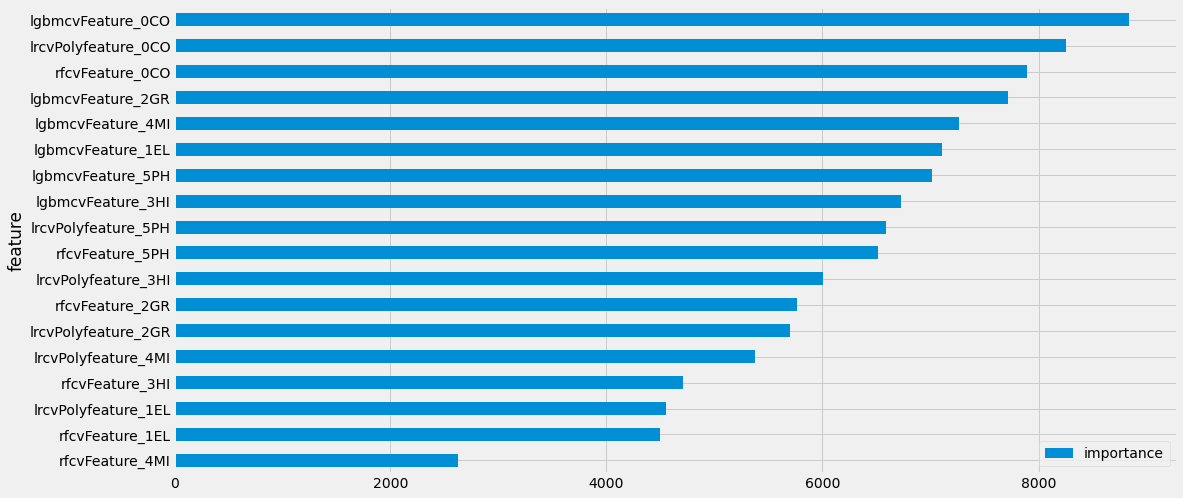

In [33]:
imp = pd.DataFrame({'feature': feature_names, 'importance': clf.feature_importances_})
imp = imp.sort_values('importance').set_index('feature')
imp.plot(kind='barh')

### [수치형 > 범주형 변환_종속변수]

In [12]:
pt=np.zeros(shape=(1833,))
pt = pt.astype(np.int64)
for x in range(0,1833):
    pt[x] = np.argmax(p_tst[x,:])
target=le.inverse_transform(pt)
target

array(['HI', 'EL', 'HI', ..., 'PH', 'PH', 'HI'], dtype=object)

## 제출 파일 생성

In [13]:
sub = pd.read_csv(sample_file)
sub['class'] = target
sub.to_csv('C:\\Users\\USER\\Desktop\\Dataset\\sub\\lgbmstacking-sub.csv',index=False,header=False)